In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys
sys.path.append("../src/CellSNAP/")
from utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from preprocessing import *
from datasets import *

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Step I: Create spatial dataset

We first load the codex murine dataset

In [2]:
df = pd.read_csv('../data/codex_murine/features_and_metadata.csv', index_col = 0)

In [3]:
df.head()

Unnamed: 0  cellLabelInImage  cellSize         CD45        Ly6C  \
0           1                 3       283     0.000000  316.262419   
1           4                 7       215     0.000000    0.000000   
2           5                11       397     0.000000  372.035233   
3           7                13       500  2966.989105  337.537437   
4           9                15       838  3797.157518  665.627685   

           TCR        Ly6G         CD19        CD169        CD106  ...  \
0   595.768897   49.077602   608.994748   322.609557     0.000000  ...   
1   134.472468    0.000000  1431.469046    73.665657     0.000000  ...   
2   899.713809  261.276071   605.481258  1023.287300  1152.344425  ...   
3   329.896108   37.743424   671.873764    51.828695    49.372156  ...   
4  1938.002387  368.658711  2616.937947  1682.991647  3003.585919  ...   

          CD35      CD2135         CD44          nucl       NKp46  \
0   217.914412   69.250551     0.000000   9100.068826  572.555576   
1  1135.190597   96.309696     0.000000  15071.640583    0.000000   
2   488.606413  245.895189   236.229915  16381.046106  769.252953   
3     0.000000    0.000000   942.795851   2283.347509  312.484433   
4  1822.097852  392.223150  5141.479714  23181.488067  575.791169   

   cluster.term  centroid_x   centroid_y  field_of_view  cluster.termV2  
0         Other    7.717314   240.809187              1          Vessel  
1             B    5.916279  1334.600000              1           Other  
2         Other    9.277078  1167.989924              1          Vessel  
3             B   11.430000  1026.952000              1               B  
4           Mph   10.233890   656.547733              1             Mph  

[5 rows x 39 columns]

In [4]:
features_list = [
        'CD45',
        'Ly6C',
        'TCR',
        'Ly6G',
        'CD19',
        'CD169',
        'CD106',
        'CD3',
        'CD1632',
        'CD8a',
        'CD90',
        'F480',
        'CD11c',
        'Ter119',
        'CD11b',
        'IgD',
        'CD27',
        'CD5',
        'CD79b',
        'CD71',
        'CD31',
        'CD4',
        'IgM',
        'B220',
        'ERTR7',
        'MHCII',
        'CD35',
        'CD2135',
        'CD44',
        'nucl',
        'NKp46'
    ]

In [5]:
murine_dataset = SNAP_Dataset(df,
                             k=15,
                             feature_neighbor=15,
                             pca_components=25,
                             features_list=features_list,
                             path2img='../../data/tutorial/codex_murine/processed_images')

### Initialize the dataset

In [6]:
murine_dataset.initialize("centroid_x", "centroid_y", "cluster.termV2")

/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Calculating cell neighborhood composition matrix...


In [7]:
murine_dataset.cell_nbhd

array([[0.13333333, 0.        , 0.13333333, ..., 0.13333333, 0.2       ,
        0.        ],
       [0.13333333, 0.        , 0.06666667, ..., 0.26666667, 0.06666667,
        0.        ],
       [0.26666667, 0.        , 0.2       , ..., 0.2       , 0.06666667,
        0.        ],
       ...,
       [0.        , 0.06666667, 0.        , ..., 0.13333333, 0.        ,
        0.        ],
       [0.        , 0.06666667, 0.        , ..., 0.06666667, 0.06666667,
        0.        ],
       [0.06666667, 0.13333333, 0.        , ..., 0.06666667, 0.06666667,
        0.        ]])

### Process Images

We first read in the raw images and concatenate them to form one entire view.

In [8]:
shape_of_each_view = (1008, 1344)
shape_of_views = (9, 7)
channels=('CD45', 'nucl')
load_path = '../../data/codex_murine'

image = np.zeros((shape_of_each_view[0]*shape_of_views[0], 
                          shape_of_each_view[1]*shape_of_views[1], len(channels)))
for view_j in range(shape_of_views[1]):
    for view_i in range(shape_of_views[0]):
        view = view_j * shape_of_views[0] + view_i + 1
        img = imread(
                '{}/raw_images/focused_BALBc-1_X0{}_Y0{}.tif'.format(
                    load_path, str(view_j + 1), str(view_i + 1)
                )
            )
        image[view_i*shape_of_each_view[0]:(view_i+1)*shape_of_each_view[0],
                  view_j*shape_of_each_view[1]:(view_j+1)*shape_of_each_view[1],:] = select_useful_features(img, channels)


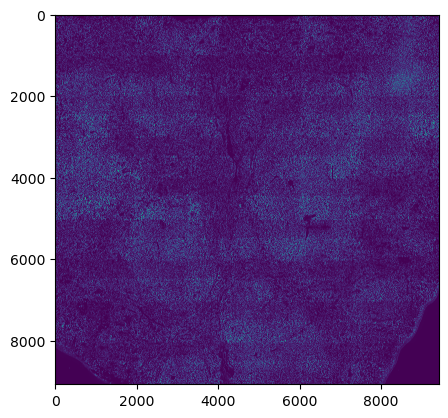

In [9]:
plt.imshow(image[:, :, 0])

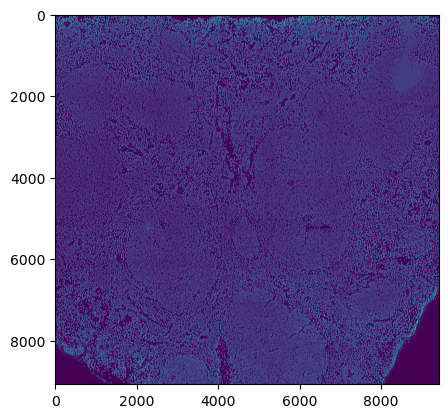

In [10]:
plt.imshow(image[:, :, 1])

In [11]:
size = 512
truncation = 0.8
murine_dataset.prepare_images(image,
                               size,
                               truncation,
                               pad=1000,
                               verbose=False)

Saving images...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 53500/53500 [04:33<00:00, 195.39it/s]


## Train CellSNAP